## Assessment 1: Deep Learning

1) Answer all questions.

2) This assessment is open-book. You are allowed to refer to any references including online materials, books, notes, codes, github links, etc.

3) Copy this notebook to your google drive (click **FILE** > **save a copy in Drive**)

4) Upload the answer notebook to your github. 

5) Submit the assessment by sharing the link to your answer notebook. 





**QUESTION 1** 

One day while wandering around a clothing store at KL East Mall, you stumbled upon a person who is choosing a dress for Hari Raya. It turns out that the person is visually impaired and had a hard time distinguishing between an abaya and a kebaya. To help people with the similar situation, you then decided to develop an AI system to identify the type of clothes using a Convolutional Neural Networks (ConvNet). In order to train the network, you decide to use the Fashion MNIST dataset which is freely available on Pytorch.


a) Given the problem, what is the most appropriate loss function to use? Justify your answer. **[5 marks]**


<span style="color:blue">
    ANSWER: Cross-Entropy Loss Function: this is due to make the model output be as close as possible to the desired output. The process of adjusting the weights is what defines model training and as the model keeps training and the loss is getting minimized </span>

b) Create and train a ConvNet corresponding to the following CNN architecture (with a modification of the final layer to address the number of classes). Please include **[10 marks]**:

    1) The dataloader to load the train and test datasets.

    2) The model definition (either using sequential method OR pytorch class method).

    3) Define your training loop.

    4) Output the mean accuracy for the whole testing dataset.

    



![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/LeNet.png)

In [1]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary


###############################################
######## THE REST OF YOUR CODES HERE ##########
###############################################



In [2]:
#1) The dataloader to load the train and test datasets.

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

# classes of fashion mnist dataset
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

train_data_size = len(train_loader.dataset)
test_data_size = len(test_loader.dataset)

print(train_data_size)
print(test_data_size)

60000
10000


In [3]:
#2) The model definition (either using sequential method OR pytorch class method).
# Class method:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=1)
        self.fc1 = nn.Linear(16 * 5* 5, 120)
        self.fc2 = nn.Linear(120, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5* 5)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
#3) Define your training loop.
#3a) LOSS and OPTIMIZER

model = CNN()

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (relu): ReLU()
)

In [5]:
#3b) Define your training loop.

import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'fashionMNIST_model_'+str(epoch)+'.pt')
            
    return model, history

In [6]:
#3c) Training
num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.1813, Accuracy: 57.2150%, 
		Validation : Loss : 0.7087, Accuracy: 73.2100%, Time: 18.1732s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.6027, Accuracy: 77.3817%, 
		Validation : Loss : 0.5805, Accuracy: 77.9800%, Time: 14.4001s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.5092, Accuracy: 81.0650%, 
		Validation : Loss : 0.5055, Accuracy: 81.4700%, Time: 15.8149s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.4609, Accuracy: 83.2100%, 
		Validation : Loss : 0.4671, Accuracy: 82.6900%, Time: 14.4540s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.4238, Accuracy: 84.6383%, 
		Validation : Loss : 0.4263, Accuracy: 84.6100%, Time: 14.3738s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.3984, Accuracy: 85.6183%, 
		Validation : Loss : 0.4075, Accuracy: 85.4700%, Time: 15.0633s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.3793, Accuracy: 86.2900%, 
		Validation : Loss : 0.4137, Accuracy: 84.9600%, Time: 14.5029s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.3664, Accura

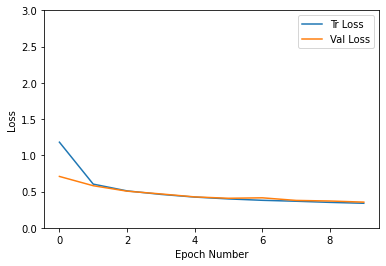

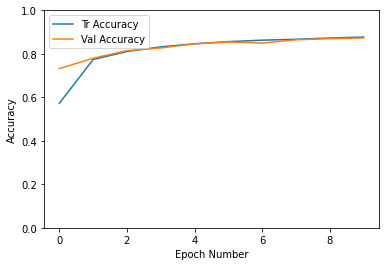

In [7]:
#3d) Loss and Accuracy Curve
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

In [8]:
#4) Output the mean accuracy for the whole testing dataset.
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
#         images = images.view(images.size(0), -1)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 87 %
Accuracy for class: T-shirt/top is 86.5 %
Accuracy for class: Trouser is 96.4 %
Accuracy for class: Pullover is 82.2 %
Accuracy for class: Dress is 91.3 %
Accuracy for class: Coat  is 76.5 %
Accuracy for class: Sandal is 96.5 %
Accuracy for class: Shirt is 58.2 %
Accuracy for class: Sneaker is 95.2 %
Accuracy for class: Bag   is 96.0 %
Accuracy for class: Ankle Boot is 94.1 %


c) Replace your defined CNN in b) with a pre-trained model. Then, proceed with a transfer learning and finetune the model for the Fashion MNIST dataset. **[10 marks]**

In [9]:
###############################################
###############YOUR CODES HERE ################
###############################################

In [10]:
#Define Pre-trained Model: Resnet50

class FashionResnet(nn.Module):
  def __init__(self, in_channels=1):
    super(FashionResnet, self).__init__()

    self.model = models.resnet50(pretrained=True)
    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Transfer learning and finetune model to fit the Fashion MNIST dataset.
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, 10)

  def forward(self, x):
    return self.model(x)


my_resnet = FashionResnet()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
#2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer_my_resnet = optim.SGD(my_resnet.parameters(), lr=0.00001, momentum=0.9)
# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_resnet.to(device)

FashionResnet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [12]:
num_epochs = 10
trained_model, history = train_and_validate(my_resnet, criterion, optimizer_my_resnet, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 2.0272, Accuracy: 31.0950%, 
		Validation : Loss : 1.7323, Accuracy: 48.9900%, Time: 66.1212s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.4939, Accuracy: 58.2317%, 
		Validation : Loss : 1.2838, Accuracy: 65.0600%, Time: 66.5441s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.1305, Accuracy: 67.6933%, 
		Validation : Loss : 0.9868, Accuracy: 71.2300%, Time: 66.2322s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.9063, Accuracy: 72.0717%, 
		Validation : Loss : 0.8175, Accuracy: 73.6600%, Time: 66.6171s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.7741, Accuracy: 74.8583%, 
		Validation : Loss : 0.7180, Accuracy: 75.6400%, Time: 66.6006s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.6970, Accuracy: 76.3817%, 
		Validation : Loss : 0.6584, Accuracy: 77.0100%, Time: 68.5634s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.6469, Accuracy: 77.6433%, 
		Validation : Loss : 0.6191, Accuracy: 78.0100%, Time: 67.1227s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.6102, Accura

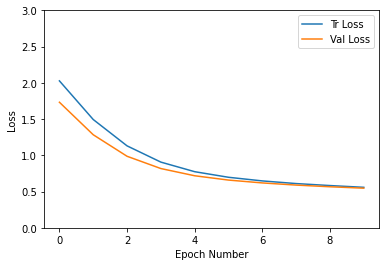

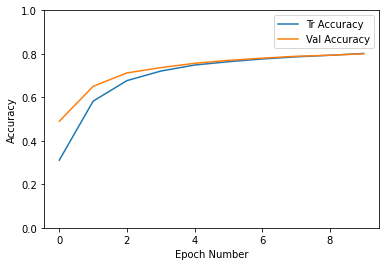

In [13]:
#Plot
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

In [14]:
#Check accuracy
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
#         images = images.view(images.size(0), -1)
        outputs = my_resnet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
#         images = images.view(images.size(0), -1)
        outputs = my_resnet(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 80 %
Accuracy for class: T-shirt/top is 82.0 %
Accuracy for class: Trouser is 93.3 %
Accuracy for class: Pullover is 62.1 %
Accuracy for class: Dress is 84.4 %
Accuracy for class: Coat  is 68.2 %
Accuracy for class: Sandal is 90.5 %
Accuracy for class: Shirt is 46.2 %
Accuracy for class: Sneaker is 85.6 %
Accuracy for class: Bag   is 93.5 %
Accuracy for class: Ankle Boot is 94.5 %


d) Using model-centric methods, propose two (2) strategies that can be used to increase the accuracy of the model on the testing dataset. **[5 marks]**


<span style="color:blue">
    Two model-centric techniques that I propose are:
     
  1. Batch Normalization
  2. Dropout </span>

e) Next, implement the two proposed model-centric techniques for the same problem as in the previous question. **[15 marks]**

In [15]:
###############################################
###############YOUR CODES HERE ################
###############################################

In [16]:
#e) Model-centric Techniques

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.dp = nn.Dropout(0.4)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.bn1(self.pool(self.relu(self.conv1(x))))
        x = self.bn2(self.pool(self.relu(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = self.dp(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [17]:
model = CNN()

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer_model = optim.Adam(model.parameters(), lr=0.001)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (relu): ReLU()
)

In [18]:
num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer_model, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.4665, Accuracy: 83.2833%, 
		Validation : Loss : 0.3400, Accuracy: 87.5600%, Time: 15.3981s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.3309, Accuracy: 87.9383%, 
		Validation : Loss : 0.3128, Accuracy: 88.4300%, Time: 15.1737s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.3000, Accuracy: 88.9300%, 
		Validation : Loss : 0.3038, Accuracy: 88.9400%, Time: 15.1302s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.2786, Accuracy: 89.7867%, 
		Validation : Loss : 0.3008, Accuracy: 88.9400%, Time: 15.3103s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.2647, Accuracy: 90.1667%, 
		Validation : Loss : 0.2848, Accuracy: 89.6700%, Time: 15.3315s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.2542, Accuracy: 90.5883%, 
		Validation : Loss : 0.2842, Accuracy: 89.7000%, Time: 16.7956s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.2441, Accuracy: 90.9017%, 
		Validation : Loss : 0.2821, Accuracy: 89.9300%, Time: 15.3845s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.2351, Accura

f) Do you see any accuracy improvement? Whether it is a "yes" or "no", discuss the possible reasons contributing to the accuracy improvement/ unimprovement. **[5 marks]**

<span style="color:blue">
    Yes, the accuracy has increased about 10%.<br>Batch normalisation raises the learning rates, which accelerates the training process. The mean and variance for each micro batch become more flexible, improving accuracy.Dropout decreases overfitting by inhibiting a subset of neurons in a layer during training. As a result,  it creates precision increases. </br> </span>

g) In real applications, data-centric strategies are essential to train robust deep learning models. Give two (2) examples of such strategies and discuss how the strategies helps improving the model accuracy. **[5 marks]**

<span style="color:blue"><br>1. Data augmentation: alters the photos by cropping, rotation, and other processes. By creating new data points from the old data, it feigns a rise in data volume. <br>2. Data MixUp: combines several characteristics of data from various types. This is done to make the model more intelligent and able to learn more.
 </span>

h) Next, implement the two proposed data-centric techniques for the same problem as in the previous question. **[10 marks]**

In [19]:
###############################################
##############YOUR CODES HERE #################
###############################################

In [20]:
#ii. Data Augmentation: image transforms

transform = transforms.Compose([transforms.RandomRotation(degrees=15),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transforms)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transforms)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

# classes of fashion mnist dataset
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

train_data_size = len(train_loader.dataset)
test_data_size = len(test_loader.dataset)

print(train_data_size)
print(test_data_size)

60000
10000


In [21]:
#use CNN MODEL

class CNN (nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=1)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [22]:
model = CNN()

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (relu): ReLU()
)

In [ ]:
num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

**QUESTION 2** **[35 marks]**

Firstly, watch this video:

https://drive.google.com/file/d/1bsypahR7I3f_R3DXkfw_tf0BrbCHxE_O/view?usp=sharing

This video shows an example of masked face recognition where the deep learning model is able to detect and classify your face even when wearing a face mask. Using the end-to-end object detection pipeline that you have learned, develop your own masked face recognition such that the model should recognize your face even on face mask while recognize other persons as "others".

Deliverables for this question are:

- the model file. Change the name to <your_name>.pt file (e.g. hasan.pt).
- a short video (~10 secs) containing your face and your friends faces (for inference).

In [24]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5
Setup complete. Using torch 1.13.0.dev20220928+cu102 (Tesla T4)


In [25]:
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="ultralytics")

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=ultralytics


In [26]:
# set up environment
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [27]:
#after following the link above, recieve python code with these fields filled in
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="bOOBXUkXSswoEBL9Gl5c")
project = rf.workspace("dl-workshop-smvxb").project("myface-fofnf")
dataset = project.version(1).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/datasets/Myface-1 in yolov5pytorch:: 100%|██████████| 198/198 [00:00<00:00, 1373.50it/s]


In [28]:
!python train.py --img 416 --batch 16 --epochs 50 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=/content/datasets/Myface-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 13 (delta 10), reused 7 (delta 4), pack-reused 0
Unpacking objects: 100% (13/13), done.
From https://github.com/ultralytics/yolov5
   6eff13b..eb64ddd  exp8       -> origin/exp8
github: up to date with https://github.com/ultralytics/yolov5 ✅
Y

In [29]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 416 --conf 0.1 --source {dataset.location}/test/images

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/datasets/Myface-1/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-187-g5ef69ef Python-3.7.14 torch-1.13.0.dev20220928+cu102 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/5 /content/datasets/Myface-1/test/images/WIN_20221007_15_04_05_Pro_jpg.rf.e5b184f45107b9323b1d9cbb75826289.jpg: 416x416 1 Me, 8.8ms
image 2/5 /content/datasets/Myface-1/test/images/WIN_20221007_15_05_57_Pro_jpg.rf.0ca803150fa3e5c25069c871259046f2.jpg: 416x416 1 Me, 8.8ms
image 3/5 /content/datasets/Myface-1

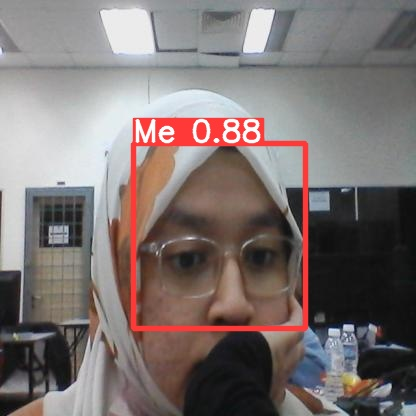

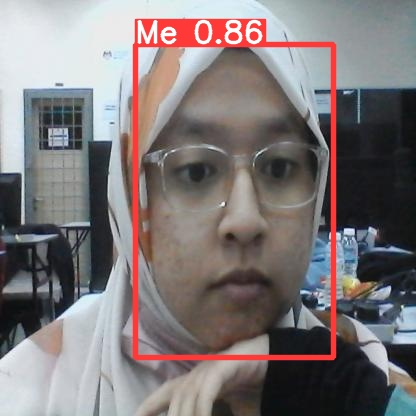

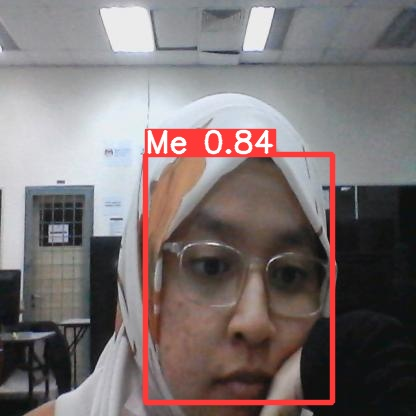

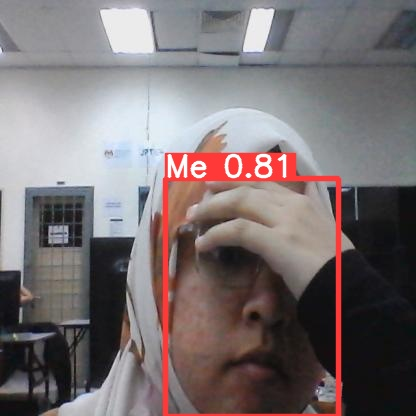

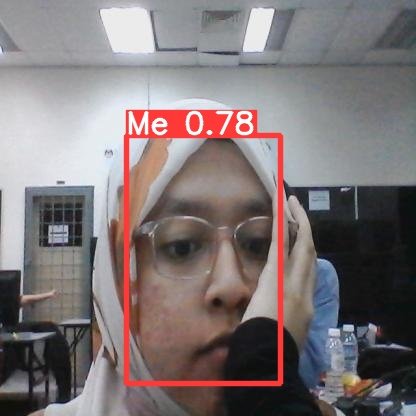

In [30]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")